In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck_clean.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck_clean.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [3]:
season = 'FMA'

### Filename for saved plots

In [4]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_Nx_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [5]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [6]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [7]:
rn_dic_models = {
    'OA_STP':'OA',
}

In [8]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [9]:
from bs_fdbck_clean.constants import path_measurement_data

## Settings: 

In [10]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [11]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [12]:
ds_smr_sat = xr.open_dataset(sat_filename)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [13]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    BC_conc                                     (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [14]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

## Annual distribution

In [15]:
dic_nice_ylabel = {
    'COT':'COT []',
    'CWP (g m^-2)':'CWP [gm$^{-2}$]', 
    'OA (microgram m^-3)':'OA [$\mu$gm$^{-3}$]',
    'CER (micrometer)':'r$_{\mathrm{eff}}$ [$\mu$m]',
}

COT
CWP (g m^-2)
OA (microgram m^-3)
CER (micrometer)
Plots/dist_plot/cloud_props_Nx__annual_distribution_props_percentiles_FMA.png


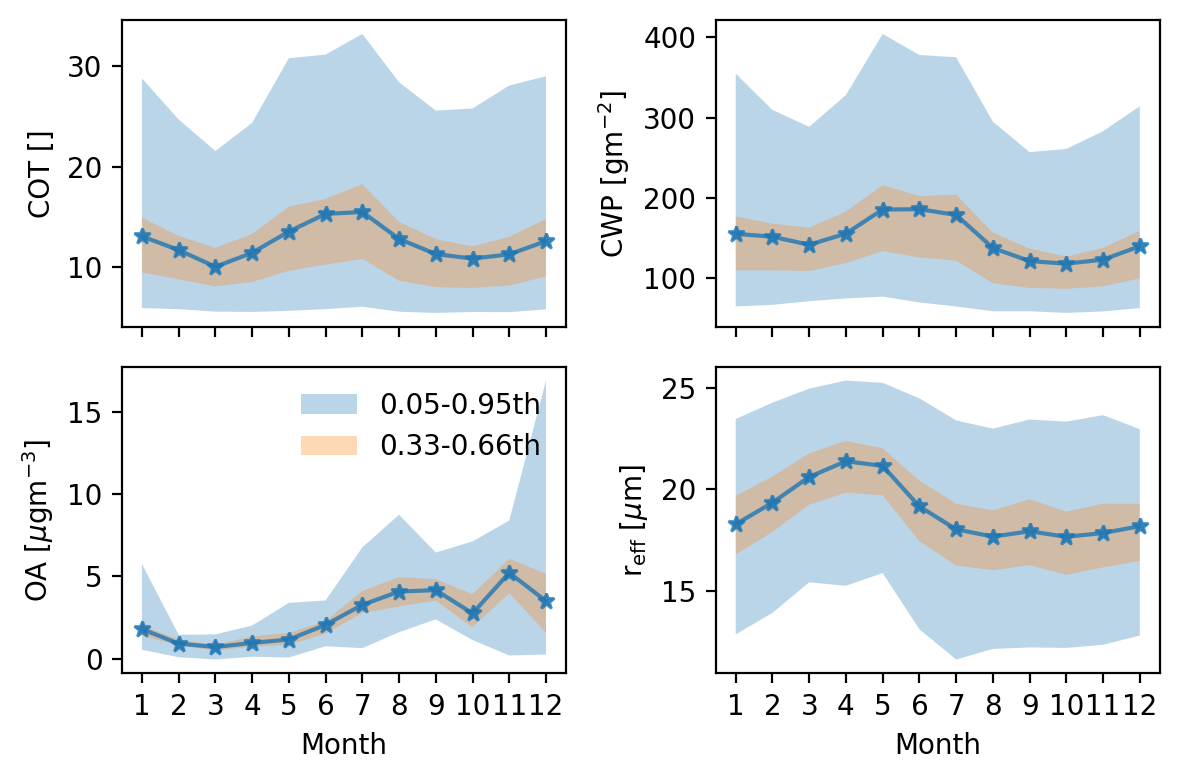

In [16]:
_df = ds_smr_sat.sel(time=slice('2014-01-01','2018-01-01')).to_dataframe()

  #  v_x = 'COT'
fig, axs = plt.subplots(2,2, dpi=200, sharex=True)
    

    
_ds_d = _df.copy().to_xarray()
_ds_d['time'] = pd.to_datetime(_ds_d['time'])

_ds_d['month'] = _ds_d['time.month']

for v_x, ax in zip(['COT','CWP (g m^-2)', 'OA (microgram m^-3)','CER (micrometer)'], axs.flatten()):
        print(v_x)
        #st_dev = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).std()
        #_dfmq = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).quantile([0.05,.33,.5, .66, .95])   
        _dfmq = _ds_d.to_dataframe().reset_index().groupby('month').quantile([0.05,.33,.5, .66, .95]).to_xarray().rename({'level_1':'quantile'})[v_x]
        mean = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).median()
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.05), _dfmq.sel(quantile=0.95),  alpha=.3, label='0.05-0.95th')
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.33), _dfmq.sel(quantile=0.66),  alpha=.3, label= '0.33-0.66th')
        mean.plot(ax = ax, alpha=0.8, marker='*') 
        ax.set_ylabel(dic_nice_ylabel[v_x])
fig.tight_layout()
axs[-1,0].legend(frameon=False)#bbox_to_anchor=(1,1,))
ax.set_xticks(list(range(1,13)))
for ax in axs.flatten():
    ax.set_xlabel('')
    
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
    
fig.tight_layout()
fn = make_fn('annual_distribution', 'props','percentiles', distplot=True)
print(fn)
#fig.savefig(fn)
plt.show()

In [17]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [18]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

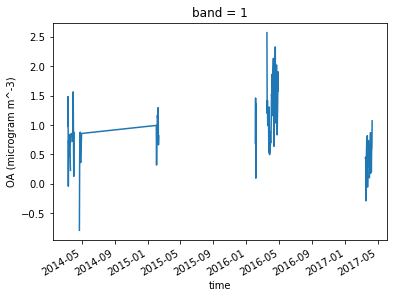

In [19]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [20]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.63925638, 1.07279969])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

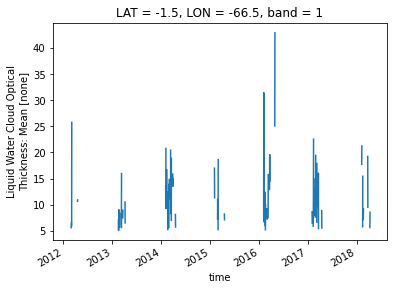

In [21]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [22]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
         'CER (micrometer)', 'COT',
         'N50-500','N100-500','N200-500']

In [23]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [24]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 625, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-02-01 ... 2018-04-30
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 nan nan nan ... nan nan nan
    CER (micrometer)     (time, LAT, LON) float32 nan nan nan ... nan nan nan
    COT                  (time, LAT, LON) float32 nan nan nan ... nan nan nan
    N50-500              (time) float64 nan nan nan nan ... 763.7 342.9 139.2
    N100-500             (time) float64 nan nan nan nan ... 434.0 141.4 63.97
    N200-500             (time) float64 nan nan nan nan ... 86.14 19.09 20.39

In [25]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [26]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [27]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-10 -1.5 -64.5             0.990000          62.0         18.480000   
                -59.5             0.990000          87.0         23.109999   
                -58.5             0.990000          84.0         20.480000   
                -57.5             0.990000         104.0         20.930000   
                -56.5             0.990000         115.0         19.070000   
...                                    ...           ...               ...   
2017-04-11 -6.5 -65.5             1.072802          93.0         15.200000   
                -59.5             1.072802         227.0         20.619999   
                -58.5             1.072802         346.0         20.900000   
           -7.5 -59.5             1.072802         226.0         21.500000   
                -58.5             1.072802         466.0         21.619999   

                             COT     N50-500    N100-500    N200-500  
time       LAT  LON                                                   
2014-03-10 -1.5 -64.5   5.170000  316.350342  259.764876  123.407339  
                -59.5   5.790000  316.350342  259.764876  123.407339  
                -58.5   6.130000  316.350342  259.764876  123.407339  
                -57.5   7.830000  316.350342  259.764876  123.407339  
                -56.5   9.080000  316.350342  259.764876  123.407339  
...                          ...         ...         ...         ...  
2017-04-11 -6.5 -65.5  10.070000  430.004186  298.137394   79.521933  
                -59.5  15.870000  430.004186  298.137394   79.521933  
                -58.5  22.869999  430.004186  298.137394   79.521933  
           -7.5 -59.5  17.709999  430.004186  298.137394   79.521933  
                -58.5  31.349998  430.004186  298.137394   79.521933  

[3549 rows x 7 columns]

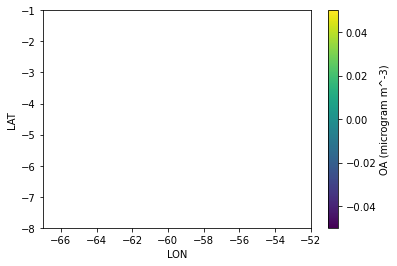

In [28]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [29]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [30]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


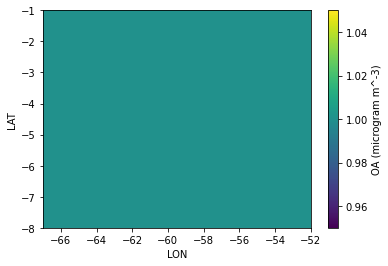

In [31]:
(~da_drop_pixels).plot()

In [32]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

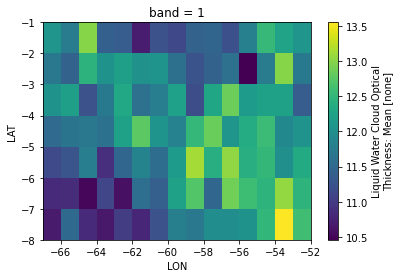

In [33]:
ds_smr_sat_JAs['COT'].mean('time').plot()

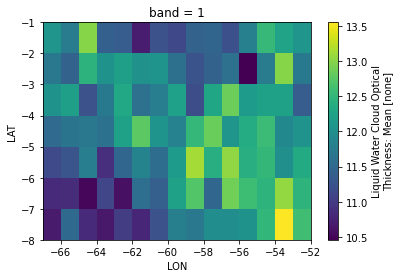

In [34]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 105.,  105.,  840., 1995., 3570., 1890., 1365.,  840.,  525.,
         210.]),
 array([-0.79      , -0.45369975, -0.1173995 ,  0.21890075,  0.555201  ,
         0.89150125,  1.2278015 ,  1.56410175,  1.900402  ,  2.23670225,
         2.5730025 ]),
 <BarContainer object of 10 artists>)

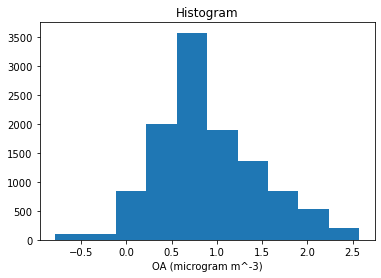

In [35]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [36]:
dic_OA_percentiles = dict()

In [37]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [38]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT,N50-500,N100-500,N200-500
time,lat,lon,,,,,,,
2012-02-01,-7.5,-66.5,NaN,127.0,22.769999,9.090000,NaN,NaN,NaN
2012-02-02,-7.5,-66.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-03,-7.5,-66.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-04,-7.5,-66.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-05,-7.5,-66.5,NaN,132.0,17.469999,11.240000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018-04-26,-1.5,-52.5,NaN,193.0,22.080000,13.090000,859.353275,464.419105,96.099565
2018-04-27,-1.5,-52.5,NaN,NaN,NaN,NaN,757.244058,549.582402,119.161451
2018-04-28,-1.5,-52.5,NaN,181.0,20.809999,12.950000,763.667424,433.962387,86.141691


df_smr_sat_JAsad model data:

## Load model data

In [39]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 
model_name_ukesm  = 'UKESM'

models =[model_name_noresm,model_name_echam,model_name_ec_earth,model_name_ukesm]

### Settings

In [40]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [41]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [42]:
l=-10
((l)%360)

350

In [43]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [44]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [45]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [46]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [47]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
model_name_noresm = 'NorESM'


#### Input files created in [03-01-01-create_file_ATTO.ipynb](03-01-01-create_file_ATTO.ipynb)

#### Input files

In [48]:
input_path_noresm = path_extract_latlon_outdata / model_name_noresm / case_name_noresm 

In [49]:
fn_noresm_csv = input_path_noresm / f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [50]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [51]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [52]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [53]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [54]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [55]:
cases_echam = [case_name_echam]

### EC-Earth

In [56]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [57]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [58]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [59]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [60]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [61]:
cases_ec_earth = [case_name_ec_earth]

### UKESM

In [62]:

case_name = 'AEROCOMTRAJ'
case_name_ukesm = 'AEROCOMTRAJ'
time_res = 'hour'
space_res='locations'
model_name='UKESM'
model_name_ukesm ='UKESM'

#### Define some strings for files

In [63]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [64]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm/ case_name_ukesm

In [65]:
fn_final_ukesm = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [66]:
fn_noresm_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/NorESM/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv')

In [67]:
cases_ukesm = [case_name_ukesm]

### Read in model data

In [68]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month

df_mod_ukesm = pd.read_csv(fn_final_ukesm_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ukesm['month'] =df_mod_ukesm.index.get_level_values(0).month

In [69]:
df_mod_echam['N50']

time        lat        lon    
2011-12-31  -2.797890  294.375          NaN
                       296.250          NaN
                       298.125          NaN
                       300.000          NaN
                       301.875          NaN
                                    ...    
2018-12-31  -6.528409  300.000    467.39522
                       301.875    467.39522
                       303.750    467.39522
                       305.625    467.39522
                       307.500    467.39522
Name: N50, Length: 61392, dtype: float64

## Pick out months:

In [70]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]
df_mod_ukesm = df_mod_ukesm[df_mod_ukesm['month'].isin(season2month[season])]

<AxesSubplot:ylabel='Frequency'>

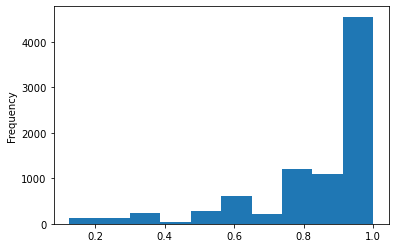

In [71]:
df_mod_echam['cl_time_ct'].plot.hist()

### Organize data in dictionary

In [72]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df[model_name_ukesm] = df_mod_ukesm

dic_df['Observations'] = df_hyy_1



### Not included anymore: *Scale CWP down for EC-Earth

_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7

    _df['scaled'] = True
    print('scaling CWP in EC-Earth')
dic_df[model_name_ec_earth]  = _df

## Check everythign is fine:

In [73]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 625, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2018-04-30
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/55)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc           (time, lat, lon) float64 4.999e-29 1.137e-28 ... 5.342e-29
    COT             (time, lat, lon) float64 11.33 7.694 nan ... nan 9.523 16.68
    clfr_mask       (time, lat, lon) float64 1.0 1.0 nan 1.0 ... 1.0 nan 1.0 1.0
    CWP             (time, lat, lon) float64 135.0 96.62 nan ... nan 105.4 139.4
    lcdnc_ct_cm3    (time, lat, lon) float64 1.566 1.009 nan ... nan 12.3 12.52
    ...              ...
    N50-500         (time, lat, lon) float64 316.2 316.2 316.2 ... 258.6 258.6
    mmrtrN200       (time, lat, lon) float64 2.762e+07 2.762e+07 ... 1.156e+07
    N100            (ti

## Rename variables:


In [74]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',
    'N100-500_STP':'N100-500',
    'N50-500_STP':'N50-500',
    'N200-500_STP':'N200-500',


}
rn_dic_ukesm = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',
    'N100-500_STP':'N100-500',
    'N50-500_STP':'N50-500',
    'N200-500_STP':'N200-500',


}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',
    'N100-500_STP':'N100-500',
    'N50-500_STP':'N50-500',
    'N200-500_STP':'N200-500',

}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',
    'N100-500_STP':'N100-500',
    'N50-500_STP':'N50-500',
    'N200-500_STP':'N200-500',

}

In [75]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    model_name_ukesm:rn_dic_ukesm,
    'Observations': rn_dic_obs
}

## Calculate Nx-500

In [76]:
for mod in models:
    print(mod)
    if 'N500_STP' not in dic_df[mod].columns:
        print('Cant find N500_STP')
    else:
        for v in ['N50_STP','N100_STP','N200_STP']:
            _v = v.split('_')[0]
            v_n = f'{_v}-500_STP'
            dic_df[mod][v_n] = dic_df[mod][v] - dic_df[mod]['N500_STP']

NorESM
ECHAM-SALSA
Cant find N500_STP
EC-Earth
UKESM


In [77]:
for mod in models:
    print(mod)
    if 'N500' not in dic_df[mod].columns:
        print('Cant find N500')
    else:
        for v in ['N50','N100','N200']:
            _v = v.split('_')[0]
            v_n = f'{_v}-500'
            dic_df[mod][v_n] = dic_df[mod][v] - dic_df[mod]['N500']

NorESM
Cant find N500
ECHAM-SALSA
EC-Earth
Cant find N500
UKESM
Cant find N500


#### Fix NorESM having OA as well as OA_STP

In [78]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [79]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [80]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    print(mod)
    print(_rn_dic)
    for v in ['OA','N100','N50','N200','N500','N100-500','N50-500','N200-500']:
        if (v in dic_df[mod].columns) & (f'{v}_STP' in dic_df[mod].columns):
            if (f'{v}_STP' in _rn_dic):
                if (_rn_dic[f'{v}_STP']==v):
                    dic_df[mod] = dic_df[mod].drop([v], axis=1)
                    print(f'dropping {v} in favor of {v}_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

NorESM
{'TGCLDLWP_incld': 'CWP', 'TOT_CLD_VISTAU_s_incld': 'COT', 'ACTREL_incld': 'r_eff', 'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500', 'N100-500_STP': 'N100-500', 'N50-500_STP': 'N50-500', 'N200-500_STP': 'N200-500'}
dropping OA in favor of OA_STP
ECHAM-SALSA
{'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500', 'N100-500_STP': 'N100-500', 'N50-500_STP': 'N50-500', 'N200-500_STP': 'N200-500'}
EC-Earth
{'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500', 'N100-500_STP': 'N100-500', 'N50-500_STP': 'N50-500', 'N200-500_STP': 'N200-500'}
dropping N100-500 in favor of N100-500_STP
dropping N50-500 in favor of N50-500_STP
dropping N200-500 in favor of N200-500_STP
UKESM
{'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500', 'N100-500_STP': 'N100-500', 'N50-500_STP': 'N50-500', 'N200-500_STP': 'N200-500'}
dropping OA in fa

In [81]:
dic_df[model_name_ec_earth]['N500']

time        lat    lon   
2012-02-01  -7.37  293.20    8.994051
                   293.91    8.994051
                   294.61    8.994051
                   295.31    8.994051
                   296.02    8.994051
                               ...   
2018-04-30  -1.05  305.16    4.077846
                   305.86    4.077846
                   306.56    4.077846
                   307.27    4.077846
                   307.97    4.077846
Name: N500, Length: 137500, dtype: float64

In [82]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 625, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2018-04-30
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/55)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc           (time, lat, lon) float64 4.999e-29 1.137e-28 ... 5.342e-29
    COT             (time, lat, lon) float64 11.33 7.694 nan ... nan 9.523 16.68
    clfr_mask       (time, lat, lon) float64 1.0 1.0 nan 1.0 ... 1.0 nan 1.0 1.0
    CWP             (time, lat, lon) float64 135.0 96.62 nan ... nan 105.4 139.4
    lcdnc_ct_cm3    (time, lat, lon) float64 1.566 1.009 nan ... nan 12.3 12.52
    ...              ...
    N50-500         (time, lat, lon) float64 316.3 316.3 316.3 ... 258.6 258.6
    mmrtrN200       (time, lat, lon) float64 2.762e+07 2.762e+07 ... 1.156e+07
    N100   

In [83]:
dic_df[model_name_echam]['N100']

time        lat        lon    
2012-02-01  -2.797890  294.375    107.628185
                       296.250    107.628185
                       298.125    107.628185
                       300.000    107.628185
                       301.875    107.628185
                                     ...    
2018-04-30  -6.528409  300.000     81.650910
                       301.875     81.650910
                       303.750     81.650910
                       305.625     81.650910
                       307.500     81.650910
Name: N100, Length: 15000, dtype: float64

<AxesSubplot:ylabel='Frequency'>

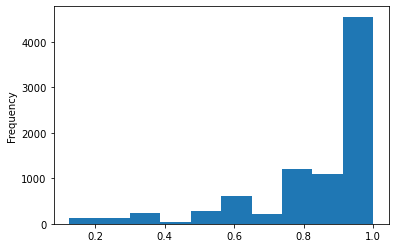

In [84]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

## Group by cloud water path 

#### Predefined bins

In [85]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ukesm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




## Mask data

### moved to pre-processing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top

### Bin model data:

CWP above 50. 

In [86]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
     'N50','N100','N200','N500',
     'N100-500','N50-500','N200-500',
       'OA_low', 'OA_high', 'OA_category']

### Calculate CWP and high/low categories in models

In [87]:
varl_categories = ['OA','N100-500','N200-500','N50-500']#,'CLDFREE']

In [88]:
varlist_notna = ['OA','CWP','COT','r_eff','N100-500','N200-500','N50-500']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [89]:
n_bins = 7

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name in ['UKESM','EC-Earth']:
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)

    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.884104785
2.1047842
74.4335699
138.1441327
16.4782237
38.326345749999994
223.62351550000002
348.67641765
NorESM
4.076777105752297
6.450284852967604
1406.7039029989787
2107.919408215806
55.48147636540867
118.12848621026386
3106.61068753233
3861.770165398251
EC-Earth


/tmp/ipykernel_2882051/3636554747.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_2882051/3636554747.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_2882051/3636554747.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_2882051/36365

2.1126693120418074
2.6052923346251653
193.21637741705976
227.32867568537173
72.58711236468284
92.1778178825542
349.711908568823
402.7188011409121
UKESM
2.2233200401162576
2.756548923025378
953.5505412090239
1099.740517182921
352.7786184658455
432.02122913614255
1253.7968738827117
1518.0183867626101
Observations
0.69256325
1.1680000000000001
171.4185356020963
255.05915944048752
43.96919467252373
71.76956306682783
271.7275710549644
377.88407844194256


/tmp/ipykernel_2882051/3636554747.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_2882051/3636554747.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_2882051/3636554747.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_2882051/36365

In [90]:
dic_df.keys()
ds_ec = dic_df['EC-Earth'].to_xarray()

In [91]:
a = dic_df['NorESM'].T.duplicated()

In [92]:
a.index

Index(['station', 'TOT_CLD_VISTAU', 'FSNT', 'TGCLDCWP', 'FSNTCDRF',
       'TOT_CLD_VISTAU_s', 'ACTNL', 'COT', 'FSUS_DRF', 'CWP',
       ...
       'N50-500_high', 'N50-500_mid_range', 'N50-500_category', 'CWP_cut',
       'CWP_cutl', 'CWP_cutlm', 'CWP_cut2', 'CWP_cut2l', 'CWP_cut2lm',
       'CWP_cut2lmid'],
      dtype='object', length=124)

In [93]:
ds_no = dic_df['NorESM'].to_xarray()

In [94]:
dic_df[model_name_ec_earth]['OA']

time        lat    lon   
2012-02-01  -7.37  302.34    1.874698
                   303.05    1.874698
                   303.75    1.874698
                   304.45    1.874698
            -6.67  301.64    1.874698
                               ...   
2018-04-30  -1.05  301.64    1.842461
                   302.34    1.842461
                   303.05    1.842461
                   304.45    1.842461
                   305.16    1.842461
Name: OA, Length: 35510, dtype: float64

In [95]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props_Nx__percentile_OA_OA_perc_FMA.csv


,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.884105,2.104784,3.084420,0.455112,1.220679
NorESM,4.076777,6.450285,8.583221,2.965201,2.373508
EC-Earth,2.112669,2.605292,2.915669,1.888359,0.492623
UKESM,2.223320,2.756549,3.167057,2.015614,0.533229
Observations,0.692563,1.168000,1.584301,0.467500,0.475437


<AxesSubplot:ylabel='Frequency'>

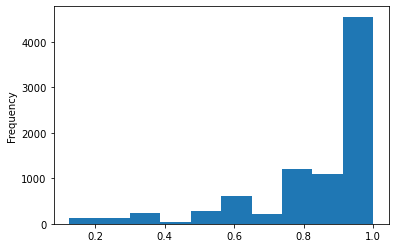

In [96]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [97]:
OA_percentile_df

,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.884105,2.104784,3.084420,0.455112,1.220679
NorESM,4.076777,6.450285,8.583221,2.965201,2.373508
EC-Earth,2.112669,2.605292,2.915669,1.888359,0.492623
UKESM,2.223320,2.756549,3.167057,2.015614,0.533229
Observations,0.692563,1.168000,1.584301,0.467500,0.475437


## Quantile cut

In [98]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [99]:
palette = 'Set2'

In [100]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [101]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
287
NorESM
274
EC-Earth
232
UKESM
123
Observations
26


3549
Plots/dist_plot/cloud_props_Nx_distribution_mod_obs_COT_count_FMA.png


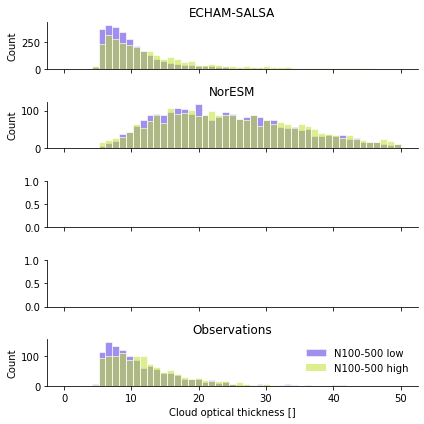

In [102]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'N100-500'
v_hue_cat = f'{v_hue}_category'
hue_order=[f'{v_hue} low', f'{v_hue} high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key in ['EC-Earth','UKESM']:
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue_cat,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=f'{v_hue} low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=f'{v_hue} high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness []')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [103]:
_df = dic_df['UKESM'].copy()
_df.columns

Index(['station', 'liq_frac_cwp', 'CWP', 'r_eff', 'month', 'ismonth1',
       'ismonth2', 'ismonth3', 'ismonth4', 'ismonth5', 'ismonth6', 'ismonth7',
       'ismonth8', 'ismonth9', 'ismonth10', 'ismonth11', 'ismonth12', 'isJuly',
       'isAug', 'isJA', 'isSummer', 'model_level', 'N200', 'N100', 'N200-500',
       'N50-500', 'N100-500', 'OA', 'N500', 'T_C', 'N50', 'year', 'OA_low',
       'OA_high', 'OA_mid_range', 'OA_category', 'N100-500_low',
       'N100-500_high', 'N100-500_mid_range', 'N100-500_category',
       'N200-500_low', 'N200-500_high', 'N200-500_mid_range',
       'N200-500_category', 'N50-500_low', 'N50-500_high', 'N50-500_mid_range',
       'N50-500_category', 'CWP_cut', 'CWP_cutl', 'CWP_cutlm', 'CWP_cut2',
       'CWP_cut2l', 'CWP_cut2lm', 'CWP_cut2lmid', 'CWP_qcut', 'CWP_qcutl'],
      dtype='object')

3549
Plots/dist_plot/cloud_props_Nx_distribution_mod_obs_CWP_count_FMA.png


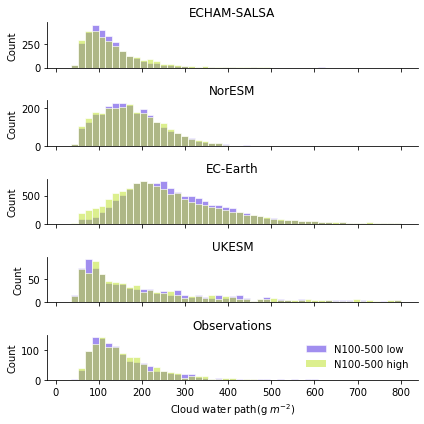

In [104]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,800)
v_x = 'CWP'
x_cut = 800
v_hue = 'N100-500'
v_hue_cat = f'{v_hue}_category'
hue_order=[f'{v_hue} low', f'{v_hue} high'][::-1]
_bins = np.linspace(20,800)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue_cat,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=f'{v_hue} low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=f'{v_hue} high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



<AxesSubplot:ylabel='Frequency'>

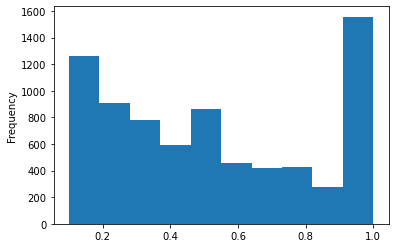

In [105]:
_df = dic_df['NorESM']
_df['FCTL'].plot.hist()

In [106]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8511

8511
7538
35510
2477
3549
Plots/dist_plot/cloud_props_Nx_distribution_mod_obs_r_eff_count_FMA.png


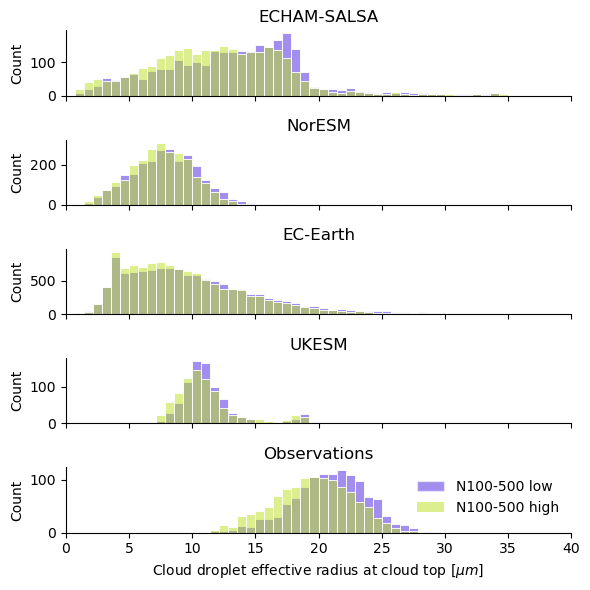

In [107]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'N100-500'
v_hue_cat = f'{v_hue}_category'
hue_order=[f'{v_hue} low', f'{v_hue} high'][::-1]
_bins = np.linspace(0,35)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue_cat,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=f'{v_hue} low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=f'{v_hue} high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [108]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [109]:
ds_nor = dic_df['NorESM'].to_xarray()

# Calculate difference between high OA and low


In [110]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model

In [111]:
palette_OA_2 = palette_OA[::-1]

In [112]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [113]:
from sklearn.utils import resample

## Bootstrap resampling 

In [114]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [115]:
hue_var = 'N100-500'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']

itterations = 50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var_cat].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var_cat].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var_cat] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var_cat] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
422
length of 67 is 538 and 579
number of days is 175 and 212
50000
length of 93 is 799 and 684
number of days is 178 and 216
50000
length of 121 is 605 and 521
number of days is 175 and 201
50000
length of 149 is 378 and 344
number of days is 150 and 173
50000
length of 178 is 200 and 215
number of days is 115 and 130
50000
length of 207 is 119 and 166
number of days is 83 and 107
50000
length of 262 is 191 and 322
number of days is 103 and 147
50000
NorESM
Total number of days:
378
length of 72 is 256 and 302
number of days is 102 and 122
50000
length of 107 is 413 and 405
number of days is 131 and 150
50000
length of 142 is 520 and 470
number of days is 148 and 155
50000
length of 178 is 463 and 467
number of days is 137 and 147
50000
length of 215 is 384 and 353
number of days is 137 and 127
50000
length of 252 is 222 and 268
number of days is 111 and 115
50000
length of 307 is 252 and 248
number of days is 110 and 112
50000
EC-Earth
UKESM
Observat

In [116]:
v = 'COT'
v_hue = 'N100-500'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info
ECHAM-SALSA
1.7851239943069854
NorESM
0.7393671722054366
Observations
0.8265029559288674


In [117]:
dic_median_CI['r_eff'].keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [118]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


In [119]:
dic_season_nicename = {
    'JFM':'Jan-Mar',
    'FMA':'Feb-Apr',
    'FMAM':'Feb-May',
    'JFMAM':'Jan-May',
    'MAM':'Mar-May',
    'JA':'July-Aug',
}

# Final plot: 

In [120]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    #'science',
    'acp',
    #'nature',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

fonts = {'family':'sans-serif', 'sans-serif': 'DejaVu Sans'}

import matplotlib as mpl
mpl.rc('font',**fonts)

Plots/rel_plot/cloud_props_Nx_r_eff_diff_median_N100-500_COT_CWP_cut2lm_FMA.png


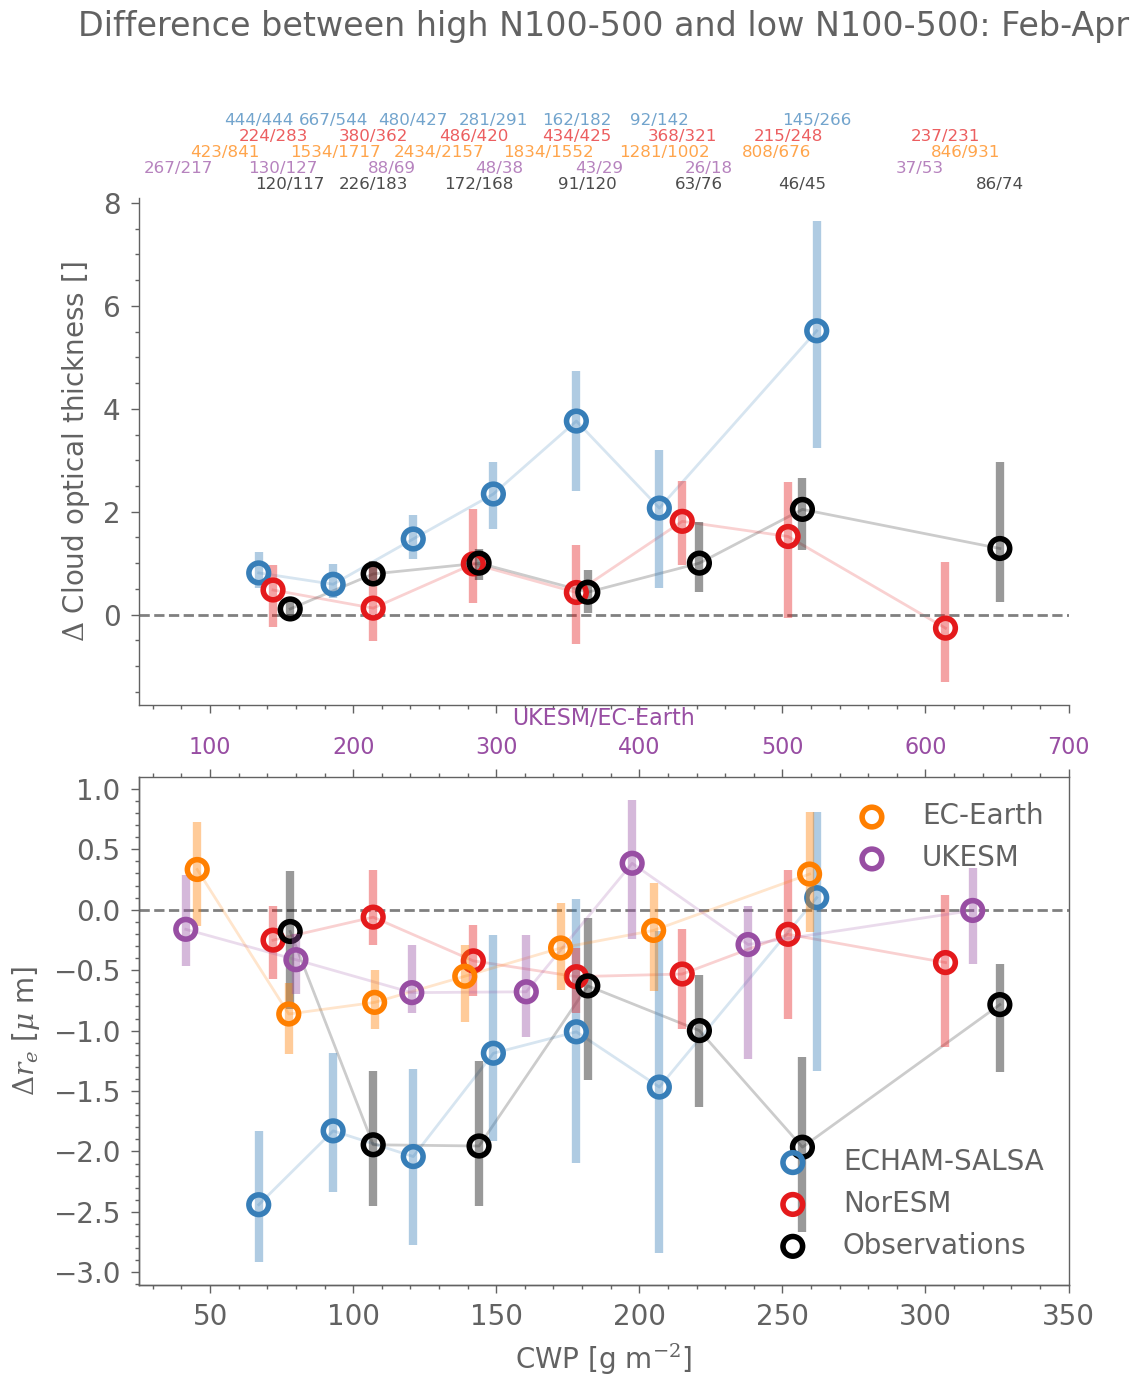

In [121]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_var = 'N100-500'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']


xlim = [25,350]
xlim2 = [50,700]
ylim2 =[-3.3,2]# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
ax_num_ukesm =axs_all[0].twiny()
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0





for ax_use, y_var in zip(axs,[y_var1, y_var2]):
    if y_var !='COT':
        ax_use_twin = ax_use.twiny()

    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        if key in ['UKESM','EC-Earth']:
            ax = ax_use_twin
            ax.set_xlabel('UKESM/EC-Earth', color=cdic_model[key], fontsize=8)  # we already handled the x-label with ax1
            ax.tick_params(axis='x', labelcolor=cdic_model[key])

        else:
            ax = ax_use
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key

        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:

            si = df_number.loc[xi]['n_str']
            if key in ['UKESM','EC-Earth']:
                xi = xi*((ax_use.get_xlim()[1]-ax_use.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
                #ax_num_ukesm.text(xi, y_pos, si,
                #    c = cdic_model[key],
                #        fontsize=6,
                #    horizontalalignment='center',
                #        alpha=.7,
                #   )
            #else:
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                           )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num_ukesm.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
ax_num_ukesm.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
sns.despine(ax=ax_num_ukesm,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_xlim(xlim)
ax_use_twin.set_xlim(xlim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False, loc='lower right')
ax_use_twin.legend(frameon=False)
ax_use_twin.tick_params(labelsize=8)
ax_num.set_title(f'Difference between high {hue_var} and low {hue_var}: {dic_season_nicename[season]}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Calculate CIs with bootstrap: N50

In [122]:
hue_var = 'N50-500'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']

itterations =50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var_cat].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var_cat].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var_cat] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var_cat] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

Total number of days:
417
length of 67 is 543 and 566
number of days is 174 and 208
50000
length of 93 is 787 and 688
number of days is 181 and 213
50000
length of 121 is 616 and 527
number of days is 178 and 199
50000
length of 149 is 365 and 347
number of days is 149 and 167
50000
length of 178 is 199 and 230
number of days is 115 and 135
50000
length of 207 is 118 and 167
number of days is 85 and 105
50000
length of 262 is 199 and 306
number of days is 106 and 144
50000
Total number of days:
370
length of 72 is 231 and 321
number of days is 101 and 125
50000
length of 107 is 400 and 436
number of days is 131 and 153
50000
length of 142 is 488 and 467
number of days is 141 and 156
50000
length of 178 is 481 and 443
number of days is 140 and 141
50000
length of 215 is 402 and 327
number of days is 138 and 124
50000
length of 252 is 240 and 245
number of days is 115 and 108
50000
length of 307 is 262 and 269
number of days is 114 and 115
50000
Total number of days:
72
length of 78 is 1

In [123]:
v = 'COT'
v_hue = 'N50-500'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
1.7381663389181752
NorESM
0.5315366886341925
Observations
0.7963411360801049


In [124]:
dic_median_CI['r_eff'].keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [125]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


In [126]:
dic_season_nicename = {
    'JFM':'Jan-Mar',
    'FMA':'Feb-Apr',
    'FMAM':'Feb-May',
    'JFMAM':'Jan-May',
    'MAM':'Mar-May',
    'JA':'July-Aug',
}

# Final plot: 

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
Plots/rel_plot/cloud_props_Nx_r_eff_diff_median_N50-500_COT_CWP_cut2lm_FMA.png


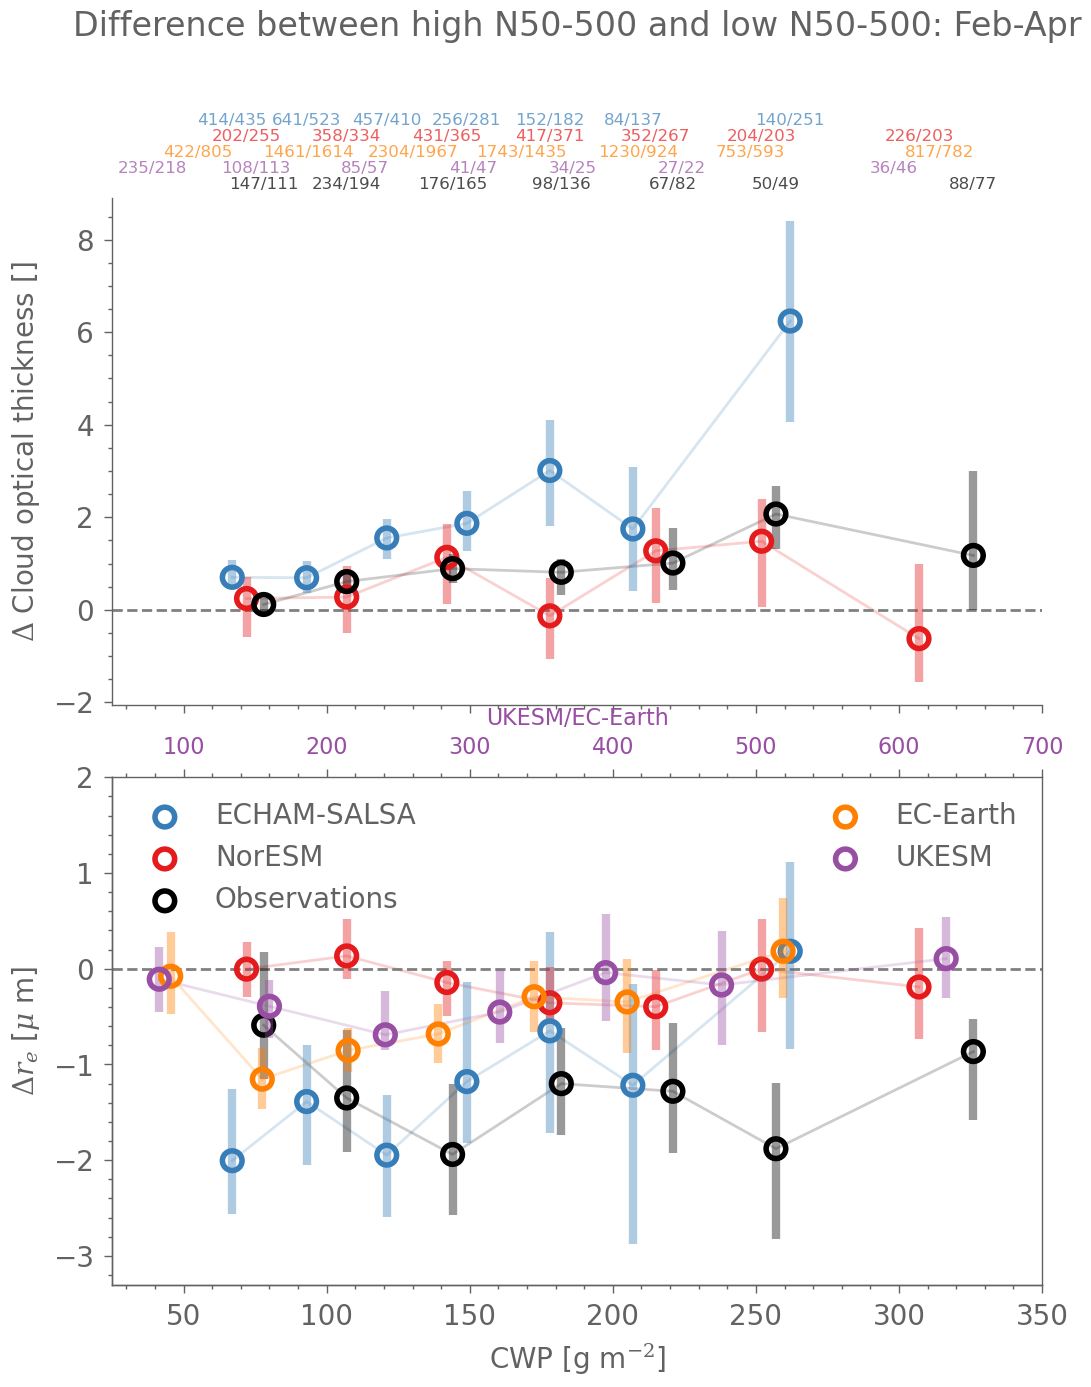

In [127]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_var = 'N50-500'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']

xlim = [25,350]
xlim2 = [50,700]
ylim2 =[-3.3,2]# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
ax_num_ukesm =axs_all[0].twiny()
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0





for ax_use, y_var in zip(axs,[y_var1, y_var2]):
    if y_var !='COT':
        ax_use_twin = ax_use.twiny()

    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        if key in ['UKESM','EC-Earth']:
            ax = ax_use_twin
            ax.set_xlabel('UKESM/EC-Earth', color=cdic_model[key], fontsize=8)  # we already handled the x-label with ax1
            ax.tick_params(axis='x', labelcolor=cdic_model[key])

        else:
            ax = ax_use
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key

        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:

            si = df_number.loc[xi]['n_str']
            if key in ['UKESM','EC-Earth']:
                xi = xi*((ax_use.get_xlim()[1]-ax_use.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
                print('hey')
                #ax_num_ukesm.text(xi, y_pos, si,
                #    c = cdic_model[key],
                #        fontsize=6,
                #    horizontalalignment='center',
                #        alpha=.7,
                #   )
            #else:
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                           )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num_ukesm.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
ax_num_ukesm.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
sns.despine(ax=ax_num_ukesm,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)
axs[1].set_xlim(xlim)
ax_use_twin.set_xlim(xlim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False, loc='upper left')
ax_use_twin.legend(frameon=False)
ax_use_twin.tick_params(labelsize=8)

ax_num.set_title(f'Difference between high {hue_var} and low {hue_var}: {dic_season_nicename[season]}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Calculate CIs with bootstrap: N20

In [128]:
hue_var = 'N200-500'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']

itterations =50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var_cat].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var_cat].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var_cat] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var_cat] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
415
length of 67 is 586 and 574
number of days is 183 and 203
50000
length of 93 is 826 and 644
number of days is 187 and 204
50000
length of 121 is 590 and 526
number of days is 179 and 197
50000
length of 149 is 333 and 372
number of days is 148 and 171
50000
length of 178 is 194 and 230
number of days is 116 and 127
50000
length of 207 is 122 and 172
number of days is 85 and 109
50000
length of 262 is 180 and 317
number of days is 100 and 145
50000
NorESM
Total number of days:
385
length of 72 is 224 and 305
number of days is 99 and 115
50000
length of 107 is 405 and 392
number of days is 146 and 143
50000
length of 142 is 527 and 460
number of days is 156 and 147
50000
length of 178 is 468 and 466
number of days is 147 and 143
50000
length of 215 is 383 and 349
number of days is 143 and 121
50000
length of 252 is 232 and 273
number of days is 118 and 110
50000
length of 307 is 254 and 262
number of days is 118 and 111
50000
EC-Earth
UKESM
Observati

In [129]:
v = 'COT'
v_hue = 'N200-500'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
1.5404858781785928
NorESM
0.7715550022397617
Observations
0.7337744126523978


In [130]:
dic_median_CI['r_eff'].keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [131]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


In [132]:
dic_season_nicename = {
    'JFM':'Jan-Mar',
    'FMA':'Feb-Apr',
    'FMAM':'Feb-May',
    'JFMAM':'Jan-May',
    'MAM':'Mar-May',
    'JA':'July-Aug',
}

# Final plot: 

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
Plots/rel_plot/cloud_props_Nx_r_eff_diff_median_N200-500_COT_CWP_cut2lm_FMA.png


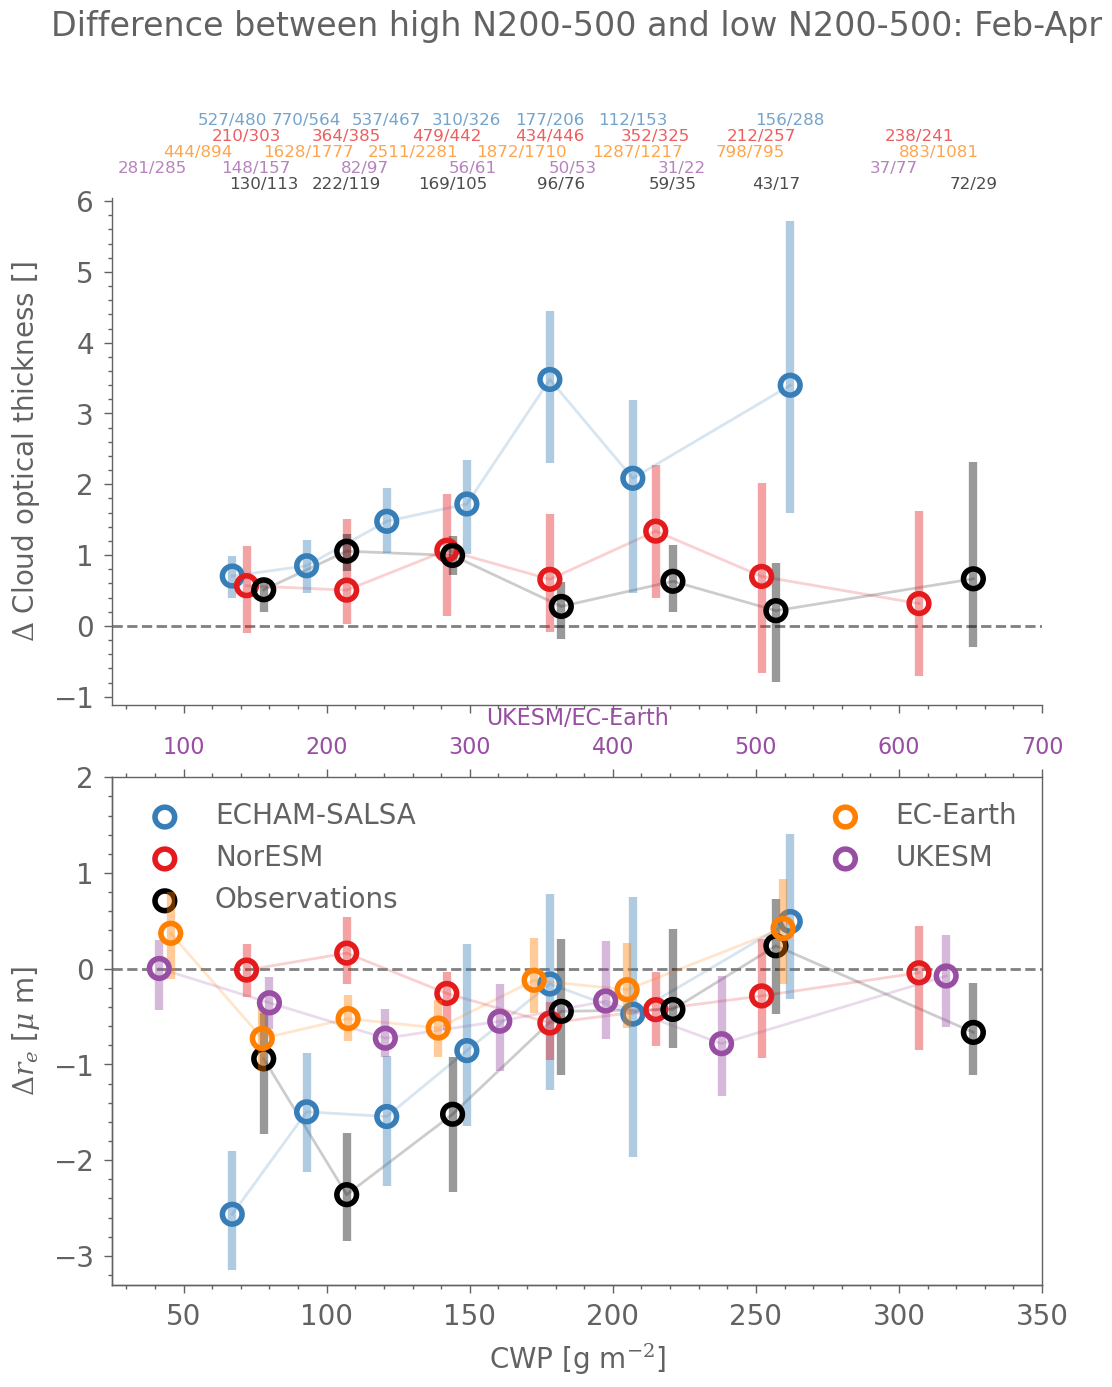

In [133]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_var = 'N200-500'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']

xlim = [25,350]
xlim2 = [50,700]
ylim2 =[-3.3,2]# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
ax_num_ukesm =axs_all[0].twiny()
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0





for ax_use, y_var in zip(axs,[y_var1, y_var2]):
    if y_var !='COT':
        ax_use_twin = ax_use.twiny()

    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        if key in ['UKESM','EC-Earth']:
            ax = ax_use_twin
            ax.set_xlabel('UKESM/EC-Earth', color=cdic_model[key], fontsize=8)  # we already handled the x-label with ax1
            ax.tick_params(axis='x', labelcolor=cdic_model[key])

        else:
            ax = ax_use
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key

        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:

            si = df_number.loc[xi]['n_str']
            if key in ['UKESM','EC-Earth']:
                xi = xi*((ax_use.get_xlim()[1]-ax_use.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
                print('hey')
                #ax_num_ukesm.text(xi, y_pos, si,
                #    c = cdic_model[key],
                #        fontsize=6,
                #    horizontalalignment='center',
                #        alpha=.7,
                #   )
            #else:
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                           )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num_ukesm.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
ax_num_ukesm.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
sns.despine(ax=ax_num_ukesm,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)
axs[1].set_xlim(xlim)
ax_use_twin.set_xlim(xlim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False, loc='upper left')
ax_use_twin.legend(frameon=False)
ax_use_twin.tick_params(labelsize=8)

ax_num.set_title(f'Difference between high {hue_var} and low {hue_var}: {dic_season_nicename[season]}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

In [134]:
v = 'COT'
v_hue = 'N100-500'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)

    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
1.5404858781785928
NorESM
0.7715550022397617
Observations
0.7337744126523978


In [135]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)

    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)



ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


## Supplementary plots

In [136]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [137]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_Nx_boxen_swarm_OA_category_COT_CWP_cutl_FMA.png


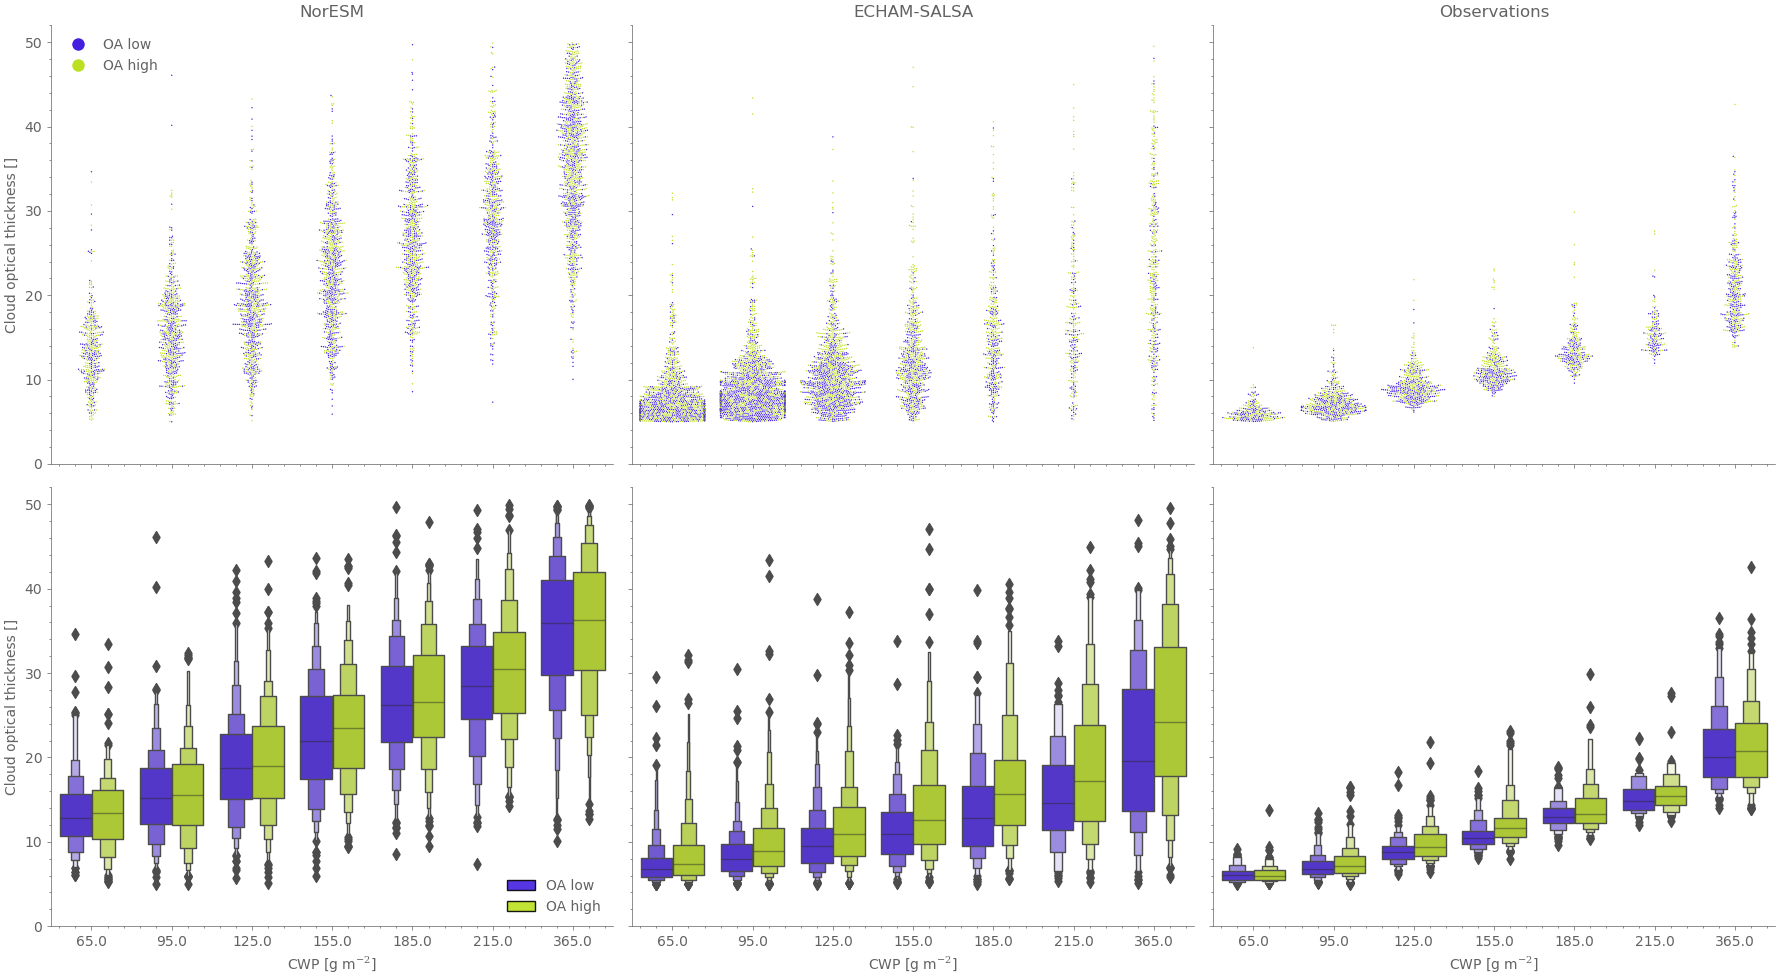

Plots/rel_plot/cloud_props_Nx_boxen_swarm_OA_category_COT_CWP_cutl_FMA.png


In [138]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical thickness []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_Nx_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


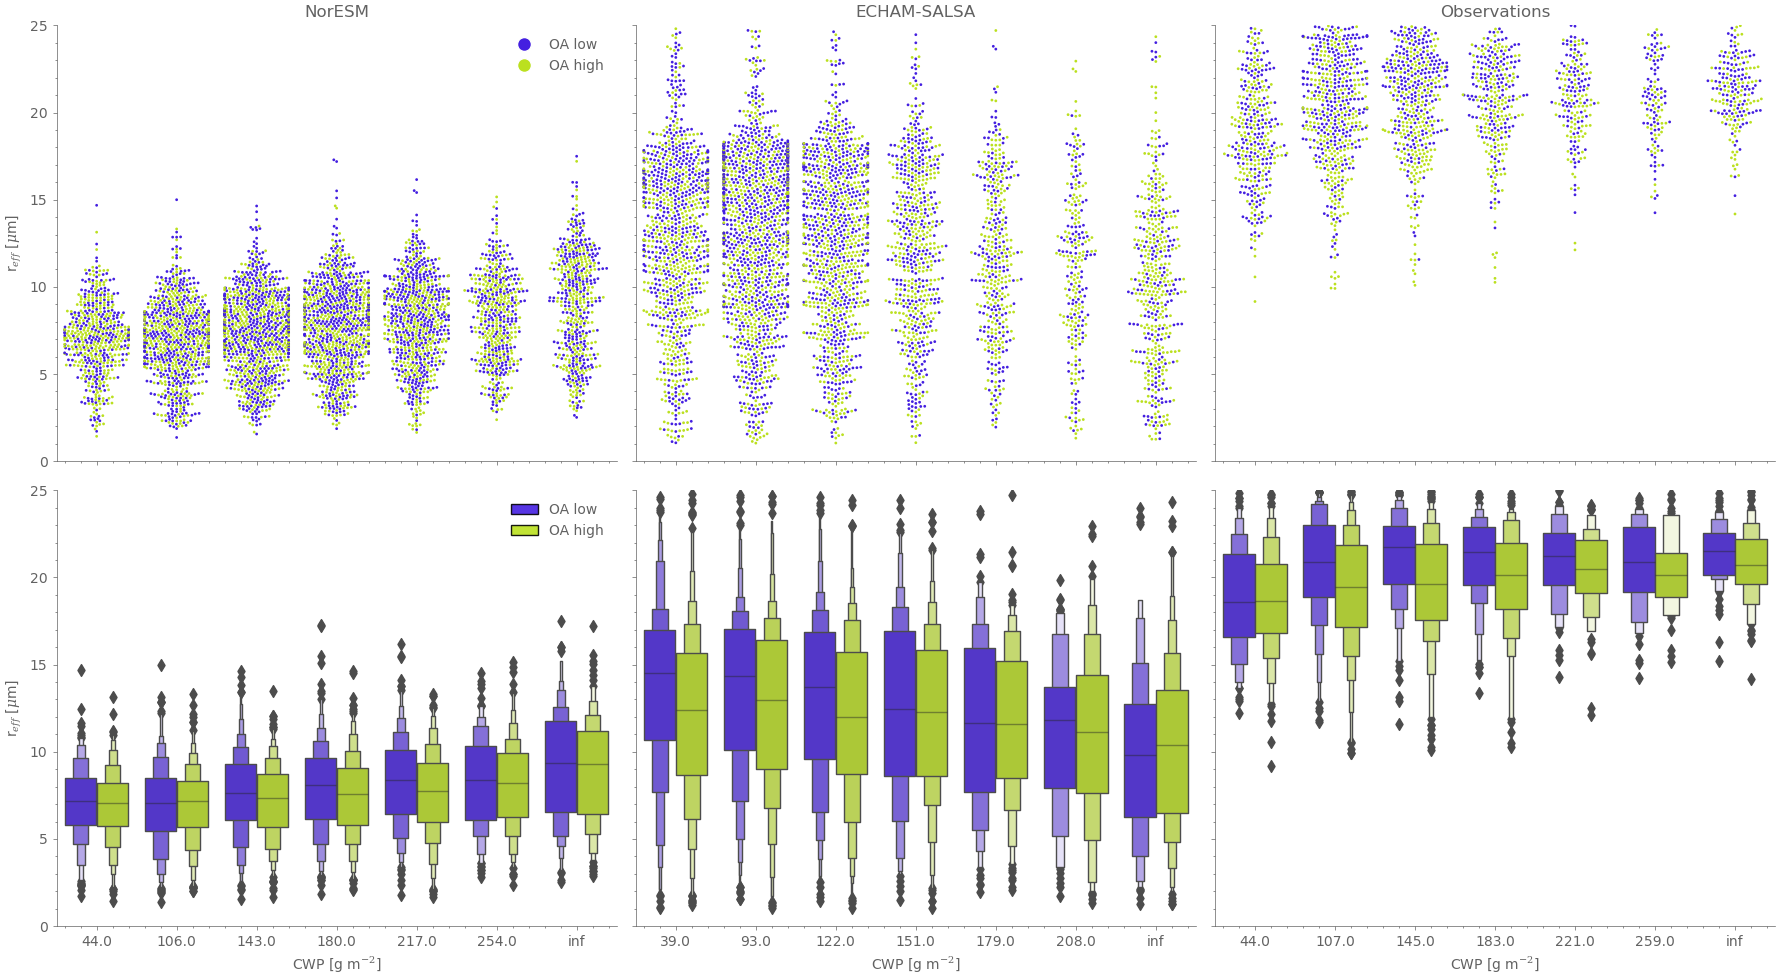

Plots/rel_plot/cloud_props_Nx_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


In [139]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_Nx_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


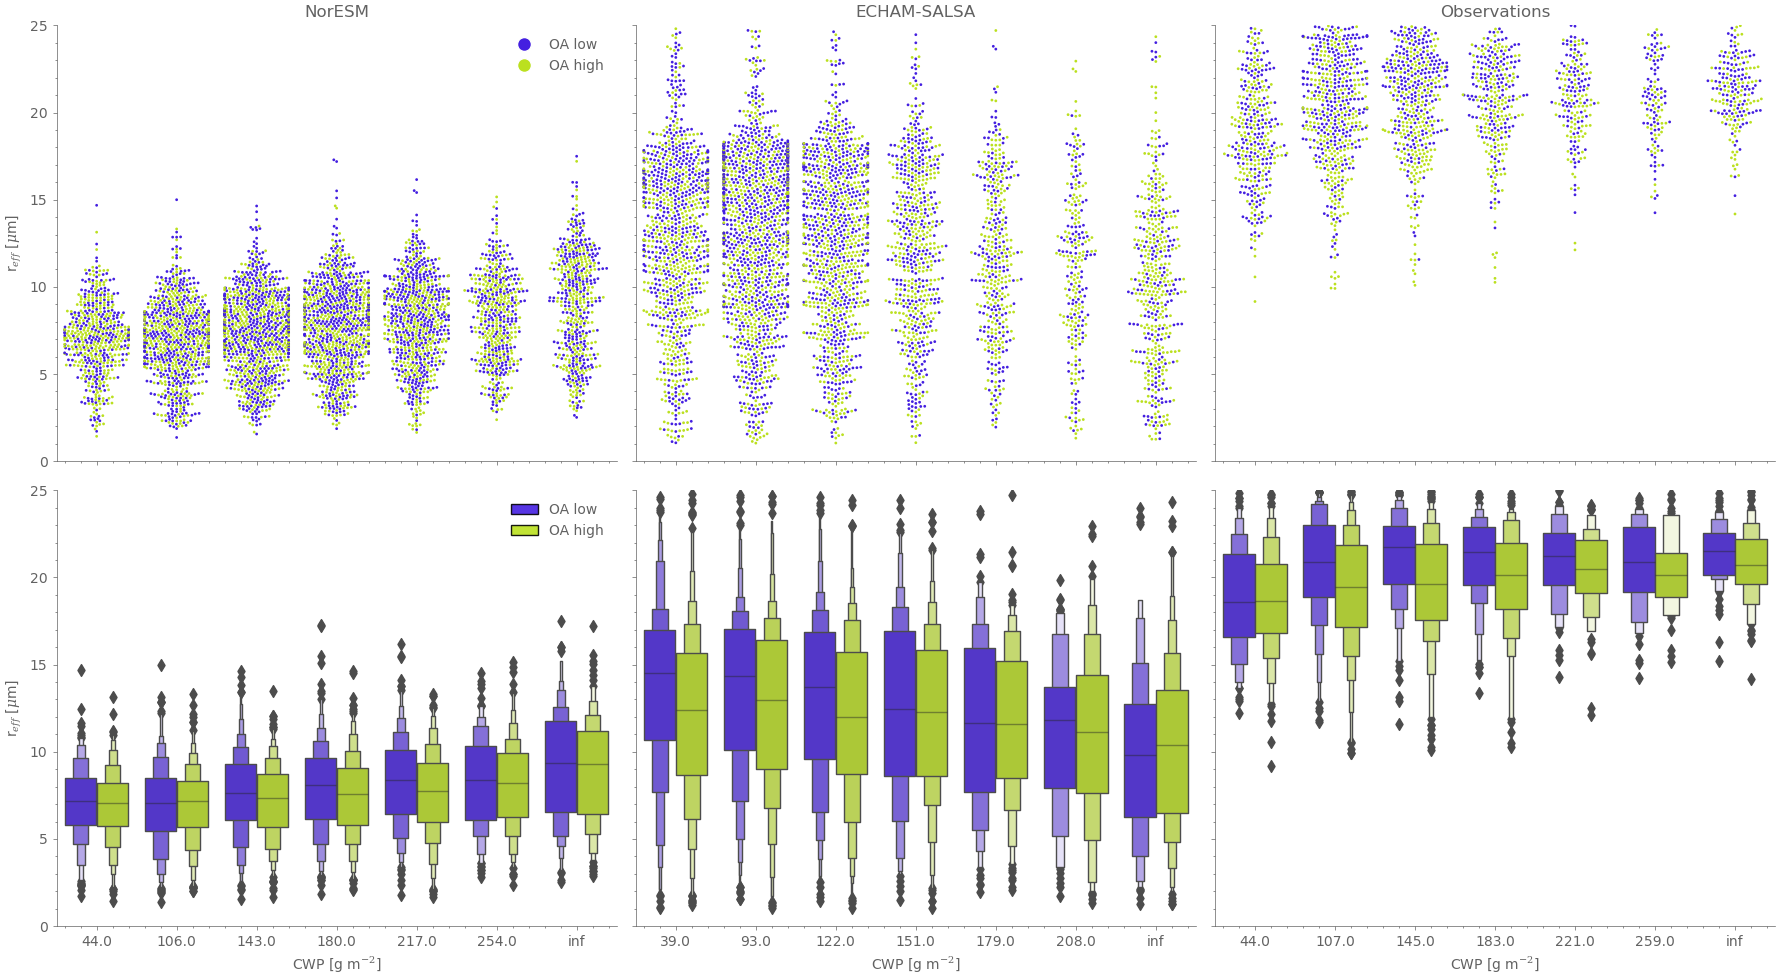

In [140]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 612 and 574
number of days is 182 and 204
50000
length of 95 is 875 and 680
number of days is 187 and 209
50000
length of 124 is 601 and 534
number of days is 178 and 197
50000
length of 153 is 298 and 376
number of days is 151 and 169
50000
length of 184 is 185 and 224
number of days is 107 and 135
50000
length of 214 is 104 and 174
number of days is 78 and 105
50000
length of 268 is 144 and 271
number of days is 88 and 129
50000


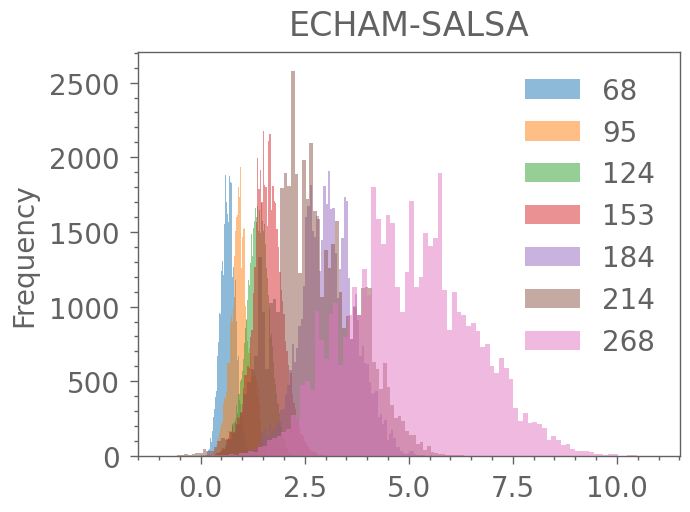

length of 68 is 178 and 229
number of days is 92 and 102
50000
length of 96 is 304 and 320
number of days is 125 and 133
50000
length of 126 is 391 and 375
number of days is 139 and 140
50000
length of 155 is 426 and 383
number of days is 136 and 137
50000
length of 184 is 362 and 360
number of days is 138 and 128
50000
length of 214 is 318 and 280
number of days is 134 and 111
50000
length of 269 is 534 and 562
number of days is 152 and 146
50000


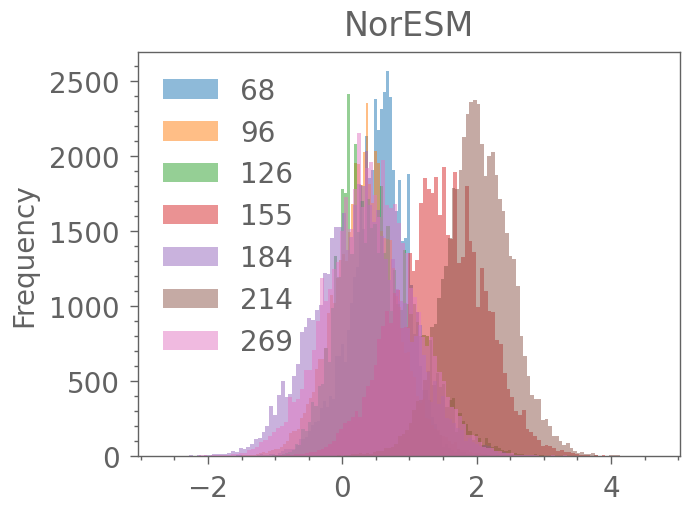

KeyError: 'COT'

In [141]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 50000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()